This post is a small extension to [my previous post](../pymc-tensorflow) where I demonstrated that it was possible to combine TensorFlow with PyMC3 to take advantage of the modeling capabilities of TensorFlow while still using the powerful inference engine provided by PyMC3.
The basic procedure involved writing a custom Theano operation that understood how to evaluate a TensorFlow tensor.
In this post, I provide a similar snippet that can be used to combine PyTorch and PyMC3 to a similar end.

One reason why I'm interested in these experiments is because I want to use these tools in a fundamentally different way than some other users.
In particular, I spend a lot of my time writing custom ops to extend the modeling languages provided by the standard model building languages since the physically motivated models that I'm interested in fitting often aren't easily or efficiently implemented using the existing stack.
For example, I recently release the ["exoplanet" library](http://exoplanet.dfm.io/en/stable/) which is an extension to PyMC3 that provides much of the custom functionality needed for fitting astronomical time series data sets.
I chose PyMC3 even though I knew that Theano was deprecated because I found that it had the best combination of powerful inference capabilities and an extensible interface.
With the development of PyMC4, it's not clear that my use case will be well supported since the sampling will be so tightly embedded in TensorFlow.
Furthermore, I don't want to be locked into using TensorFlow just so that I can take advantage of PyMC4's inference algorithms.
Instead, I'm interested in understanding how feasible it would be to fork the inference engine part of PyMC3 to build a Python-based inference library that could be used for inference with models defined in TensorFlow-probability, Pyro, Jax, or whatever comes next without a full re-write.
My key thought here is that I don't think that the modeling and inference components of a probabilistic modeling stack need to be as tightly integrated as most existing packages are.

This post doesn't answer the question, but I thought that it was worth sharing anyways.
As in the TensorFlow post, I'll demonstrate this idea using linear regression. 
Take a look [at the previous post](../pymc-tensorflow) for more details.
First, let's generate the same simulated data:

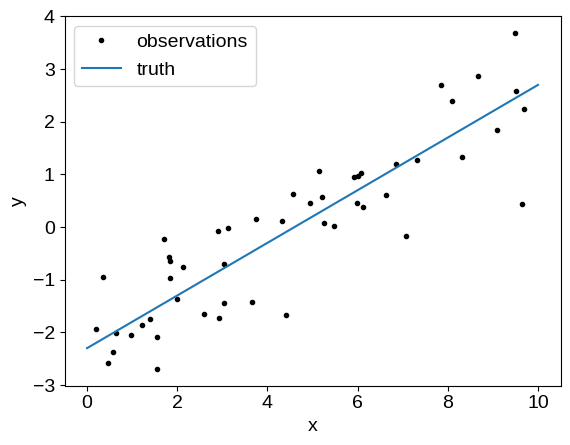

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_params = np.array([0.5, -2.3, -0.23])

N = 50
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, 50)
y = x * true_params[0] + true_params[1]
y_obs = y + np.exp(true_params[-1]) * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0] * t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

Next, let's implement the likelihood function for this simple linear model using PyTorch.

**Disclaimer:** I'm definitely not a PyTorch expert so there might be a better way to do this, but this should at least demonstrate the idea.

In [2]:
import torch


class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()

        self.m = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.b = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))
        self.logs = torch.nn.Parameter(torch.tensor(0.0, dtype=torch.float64))

    def forward(self, x, y):
        mean = self.m * x + self.b
        loglike = -0.5 * torch.sum(
            (y - mean) ** 2 * torch.exp(-2 * self.logs) + 2 * self.logs
        )
        return loglike

Now, here's a custom Theano Op that knows how to evaluate a PyTorch *scalar* and its gradient.
It would be possible to extend this work for arbitrary PyTorch tensors, but it would take a bit more book keeping.

In [3]:
import theano
import theano.tensor as tt


class TorchOp(tt.Op):
    def __init__(self, module, params, args=None):
        self.module = module
        self.params = list(params)
        if args is None:
            self.args = tuple()
        else:
            self.args = tuple(args)

    def make_node(self, *args):
        if len(args) != len(self.params):
            raise ValueError("dimension mismatch")
        args = [tt.as_tensor_variable(a) for a in args]
        return theano.graph.basic.Apply(
            self, args, [tt.dscalar().type()] + [a.type() for a in args]
        )

    def infer_shape(self, *args):
        shapes = args[-1]
        return tuple([()] + list(shapes))

    def perform(self, node, inputs, outputs):
        for p, value in zip(self.params, inputs):
            p.data = torch.tensor(value)
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

        result = self.module(*self.args)
        result.backward()

        outputs[0][0] = result.detach().numpy()
        for i, p in enumerate(self.params):
            outputs[i + 1][0] = p.grad.numpy()

    def grad(self, inputs, gradients):
        for i, g in enumerate(gradients[1:]):
            if not isinstance(g.type, theano.gradient.DisconnectedType):
                raise ValueError(
                    "can't propagate gradients wrt parameter {0}".format(i + 1)
                )
        return [gradients[0] * d for d in self(*inputs)[1:]]

Here's how we can combine these into a Theano op that knows how to evaluate the linear model using PyTorch:

In [4]:
# Instantiate the PyTorch model
model = torch.jit.script(LinearModel())

# It's useful to select the parameters directly instead of using model.parameters()
# so that we make sure that the order is as expected
params = [model.m, model.b, model.logs]

# The "forward" method of the torch op takes the data as well
args = [torch.tensor(x, dtype=torch.double), torch.tensor(y_obs, dtype=torch.double)]

# Finally put it all together
op = TorchOp(model, params, args=args)

Now we're all set to use this in a PyMC3 model:

In [5]:
import pymc3 as pm

with pm.Model() as torch_model:

    m = pm.Uniform("m", -5, 5)
    b = pm.Uniform("b", -5, 5)
    logs = pm.Uniform("logs", -5, 5)

    pm.Potential("obs", op(m, b, logs)[0])

    np.random.seed(6940)
    torch_trace = pm.sample(
        1000, tune=5000, target_accept=0.9, return_inferencedata=True, cores=1
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logs, b, m]


Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 44 seconds.


Note that unlike the TensorFlow implementation, there's no problem using multiple cores with this model and we actually get more than a factor of two increase in efficiency (probably because PyTorch has less Python overhead per call).

For comparison, we can reimplement the same model directly in PyMC3:

In [6]:
with pm.Model() as pymc3_model:

    m = pm.Uniform("m", -5, 5)
    b = pm.Uniform("b", -5, 5)
    logs = pm.Uniform("logs", -5, 5)

    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y_obs)

    np.random.seed(6940)
    pymc3_trace = pm.sample(
        1000, tune=5000, target_accept=0.9, return_inferencedata=True, cores=1
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [logs, b, m]


Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 13 seconds.


In this case, the PyMC3 model is about a factor of 2 faster than the PyTorch model, but this is a simple enough model that it's not really a fair comparison.
I expect that this gap would close for more expensive models where the overhead is less important.
Personally, I'm willing to pay some performance penalty for the benefit of being able to use whichever modeling framework I want without serious compromises when it comes to inference capabilities.

Finally, we can confirm that we got the same results (they should actually be *identical* because I used the same random number seed above):

In [7]:
import arviz as az

az.summary(torch_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.483,0.037,0.415,0.550,0.001,0.001,912.0,941.0,1.0
b,-2.226,0.197,-2.570,-1.832,0.007,0.005,891.0,964.0,1.0
logs,-0.299,0.101,-0.500,-0.118,0.003,0.002,1054.0,1131.0,1.0


In [8]:
az.summary(pymc3_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.483,0.037,0.413,0.548,0.001,0.001,954.0,1140.0,1.0
b,-2.232,0.195,-2.590,-1.863,0.006,0.005,918.0,1071.0,1.0
logs,-0.303,0.102,-0.493,-0.110,0.003,0.002,1037.0,1101.0,1.0


Looks right to me!

I think that this experiment seems pretty promising.
It demonstrates that it is feasible to sample a model implemented in PyTorch using PyMC3 with some overhead.
I expect that more expensive models like the ones I normally work on will be even more closely matched in terms of performance.
There are still some open questions, but I think that there's enough here to sketch out a plan for a common Python inference library that could be used with models defined in any modeling framework that can be called from within Python.
To zeroth order, I would like something that can do NUTS sampling where the interface is just a Python function that computes the log-probability and its derivative for a vector of parameters (and maybe some other functions for evaluating deterministics, etc.).
In the long term, it would be awesome to reproduce other functionality of PyMC3 like ADVI, but I have less experience with that so I'm not sure exactly what that would take.
Either way, I'd love to hear if you have any feedback, tips, questions, pictures of good dogs, etc.